# CS3315 Project: Random Forest Classifier

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Perceptron

In [2]:
# import data
filename = 'data/2020.06.19.csv'
df = pd.read_csv(filename)

# sample small subset
# df = df.sample(500000, random_state=78)
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765360 entries, 0 to 765359
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   avg_ipt        765360 non-null  float64
 1   bytes_in       765360 non-null  int64  
 2   bytes_out      765360 non-null  int64  
 3   dest_ip        765360 non-null  int64  
 4   dest_port      740863 non-null  float64
 5   entropy        765360 non-null  float64
 6   num_pkts_out   765360 non-null  int64  
 7   num_pkts_in    765360 non-null  int64  
 8   proto          765360 non-null  int64  
 9   src_ip         765360 non-null  int64  
 10  src_port       740863 non-null  float64
 11  time_end       765360 non-null  int64  
 12  time_start     765360 non-null  int64  
 13  total_entropy  765360 non-null  float64
 14  label          765360 non-null  object 
 15  duration       765360 non-null  float64
dtypes: float64(6), int64(9), object(1)
memory usage: 93.4+ MB


avg_ipt  bytes_in  bytes_out  dest_ip  dest_port   entropy  num_pkts_out  \
0      7.5       342       3679      786     9200.0  5.436687             2   
1      0.0         0          0      786    55972.0  0.000000             1   

   num_pkts_in  proto  src_ip  src_port          time_end        time_start  \
0            2      6     786   57392.0  1592533725648144  1592533725632946   
1            1      6   49453   49493.0  1592533744644904  1592533744644904   

   total_entropy    label  duration  
0      21860.918   benign  0.015198  
1          0.000  outlier  0.000000

In [3]:
# clean data
df.dropna(inplace=True)
df.isna().sum()

# need to clean for features that are 0 and don't make sense (bytes = 0?)

avg_ipt          0
bytes_in         0
bytes_out        0
dest_ip          0
dest_port        0
entropy          0
num_pkts_out     0
num_pkts_in      0
proto            0
src_ip           0
src_port         0
time_end         0
time_start       0
total_entropy    0
label            0
duration         0
dtype: int64

In [4]:
print('label values:', df['label'].unique())

def ordinal_encoder(category):
    dict = {'benign':0, 'outlier':1, 'malicious':2}
    return dict[category]

print('benign', ordinal_encoder('benign'))
print('outlier', ordinal_encoder('outlier'))
print('malicious', ordinal_encoder('malicious'))
df['label'] = df['label'].apply(ordinal_encoder)

label values: ['benign' 'outlier' 'malicious']
benign 0
outlier 1
malicious 2


In [5]:
features = ['avg_ipt', 
            'bytes_in', 
            'bytes_out', 
            'dest_ip', 
            'dest_port', 
            'entropy', 
            'num_pkts_in',
            'num_pkts_out', 
            'proto', 
            'src_ip', 
            'src_port', 
            'time_end', 
            'time_start', 
            'total_entropy', 
            'duration']

X = df.loc[:, features]
y = df.loc[:,'label']

In [6]:
# test/train split

from sklearn.model_selection import train_test_split

# 80/20 training/validation split
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size=.8, test_size=.2, random_state=42)

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

# should print number of shape: (num features, num entries)
print('Training set: ', 'X: ', X_train.shape, 'y: ', y_train.shape, 'Validation set: ', 'X: ', X_val.shape, 'printy: ', y_val.shape)

Training set:  X:  (592690, 15) y:  (592690,) Validation set:  X:  (148173, 15) printy:  (148173,)


In [7]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=5000, 
                                 max_depth=30, 
                                 max_leaf_nodes=16,
                                 n_jobs=-1, 
                                 min_samples_leaf=100, 
                                 min_samples_split=100)

rfc.fit(X_train, y_train)


RandomForestClassifier(max_depth=30, max_leaf_nodes=16, min_samples_leaf=100,
                       min_samples_split=100, n_estimators=5000, n_jobs=-1)

In [8]:
y_pred = rfc.predict(X_val)

In [9]:
from sklearn.tree import export_graphviz

export_graphviz(rfc.estimators_[900], out_file='rfctree.dot', 
                feature_names = features,
                class_names = ['benign', 'outlier', 'malicious'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
from subprocess import call
call(['dot', '-Tpng', 'rfctree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [10]:
# plot loss vs. accuracy (HOML p. 305)
#import matplotlib.pyplot as plt
#pd.DataFrame(history.history).plot()
#plt.grid(True)
#plt.gca().set_ylim(0,1)
#plt.show()

In [11]:
from sklearn.metrics import *
print("Predicted labels:\t", y_pred)
print("Actual labels:\t\t", y_val)
print(classification_report(y_val, y_pred))

Predicted labels:	 [0 1 0 ... 2 2 2]
Actual labels:		 [0 1 0 ... 2 2 1]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     75511
           1       1.00      0.41      0.58     24572
           2       0.77      0.99      0.86     48090

    accuracy                           0.90    148173
   macro avg       0.92      0.80      0.81    148173
weighted avg       0.92      0.90      0.88    148173



## Validate Model with Data from June 2022

In [12]:
# import data
filename = 'data/2020.06.20.csv'
df2 = pd.read_csv(filename)

# sample small subset
#df2 = df2.sample(n=100000, random_state=78)
df2.info()
df2.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770853 entries, 0 to 770852
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   avg_ipt        770853 non-null  float64
 1   bytes_in       770853 non-null  int64  
 2   bytes_out      770853 non-null  int64  
 3   dest_ip        770853 non-null  int64  
 4   dest_port      770853 non-null  int64  
 5   entropy        770853 non-null  float64
 6   num_pkts_out   770853 non-null  int64  
 7   num_pkts_in    770853 non-null  int64  
 8   proto          770853 non-null  int64  
 9   src_ip         770853 non-null  int64  
 10  src_port       770853 non-null  int64  
 11  time_end       770853 non-null  int64  
 12  time_start     770853 non-null  int64  
 13  total_entropy  770853 non-null  float64
 14  label          770853 non-null  object 
 15  duration       770853 non-null  float64
dtypes: float64(4), int64(11), object(1)
memory usage: 94.1+ MB


avg_ipt  bytes_in  bytes_out  dest_ip  dest_port   entropy  num_pkts_out  \
0  34.57143        34         29      786       5900  5.040459             7   
1  37.00000        34         29      786       5900  5.127916             7   

   num_pkts_in  proto  src_ip  src_port          time_end        time_start  \
0           10      6   28753     34406  1592614653171313  1592614652702811   
1           10      6   28753     29250  1592614652343948  1592614651847887   

   total_entropy      label  duration  
0       317.5489  malicious  0.468502  
1       323.0587  malicious  0.496061

In [13]:
# clean data
df2.dropna(inplace=True)
df2.isna().sum()

avg_ipt          0
bytes_in         0
bytes_out        0
dest_ip          0
dest_port        0
entropy          0
num_pkts_out     0
num_pkts_in      0
proto            0
src_ip           0
src_port         0
time_end         0
time_start       0
total_entropy    0
label            0
duration         0
dtype: int64

In [14]:
print('label values:', df2['label'].unique())

def ordinal_encoder(category):
    dict = {'benign':0, 'outlier':1, 'malicious':2}
    return dict[category]

print('benign', ordinal_encoder('benign'))
print('outlier', ordinal_encoder('outlier'))
print('malicious', ordinal_encoder('malicious'))
df2['label'] = df2['label'].apply(ordinal_encoder)

label values: ['malicious' 'benign' 'outlier']
benign 0
outlier 1
malicious 2


In [15]:
features = ['avg_ipt', 
            'bytes_in', 
            'bytes_out', 
            'dest_ip', 
            'dest_port', 
            'entropy', 
            'num_pkts_in',
            'num_pkts_out', 
            'proto', 
            'src_ip', 
            'src_port', 
            'time_end', 
            'time_start', 
            'total_entropy', 
            'duration']

X_22 = df2.loc[:, features]
y_22 = df2.loc[:,'label']

In [16]:
# change labels to numpy
y_22 = y_22.to_numpy()

In [17]:
# test predictions
X_test_new = X_22
test_pred_22 = rfc.predict(X_test_new)

In [18]:
print("Predicted labels:\t", test_pred_22)
print("Actual labels:\t\t", y_22)
print(classification_report(y_22, test_pred_22))

Predicted labels:	 [2 2 2 ... 2 2 2]
Actual labels:		 [2 2 2 ... 1 1 2]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    366310
           1       0.26      0.10      0.15     69389
           2       0.84      0.93      0.88    335154

    accuracy                           0.89    770853
   macro avg       0.70      0.68      0.67    770853
weighted avg       0.86      0.89      0.87    770853



[[75435     0    76]
 [  119 10114 14339]
 [  441    44 47605]]
[[366141      0    169]
 [  1554   7157  60678]
 [  2624  20320 312210]]
[[366141      0    169]
 [  1554   7157  60678]
 [  2624  20320 312210]]


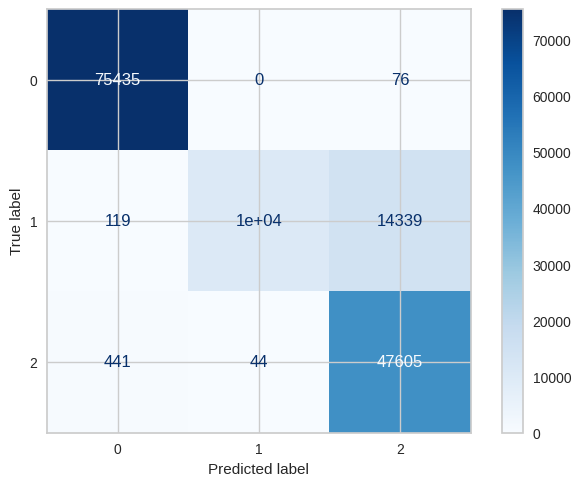

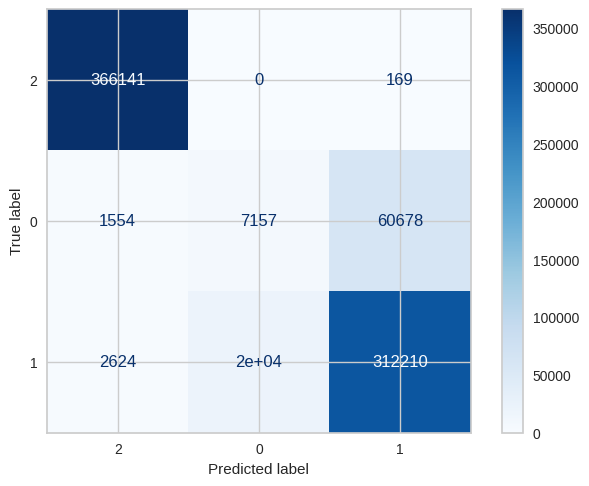

In [25]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(y_val, y_pred)

classes = df['label'].unique()
disp = ConfusionMatrixDisplay.from_estimator(
        rfc,
        X_val,
        y_val,
        display_labels= classes,
        cmap=plt.cm.Blues,
    )

print(disp.confusion_matrix)

cm22 = confusion_matrix(y_22, test_pred_22)

classes = df2['label'].unique()
disp = ConfusionMatrixDisplay.from_estimator(
        rfc,
        X_22,
        y_22,
        display_labels= classes,
        cmap=plt.cm.Blues,
    )
print(disp.confusion_matrix)
print(cm22)

/home/ahuang/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


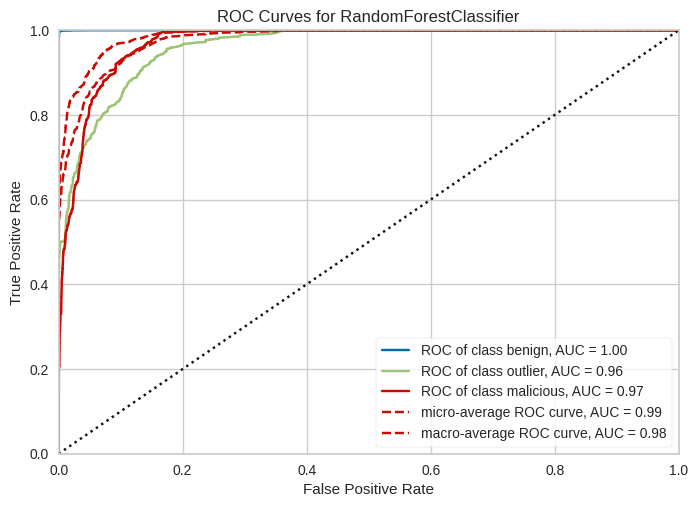

<AxesSubplot: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [23]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rfc, classes=['benign', 'outlier', 'malicious'])

visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.show()

/home/ahuang/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


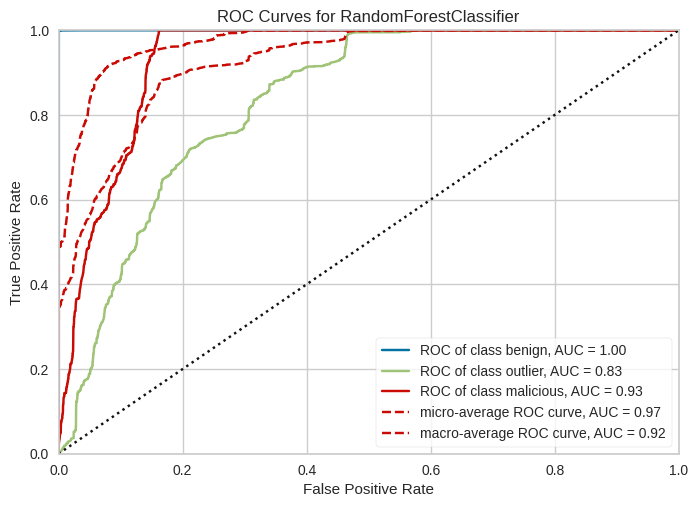

<AxesSubplot: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [24]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rfc, classes=['benign', 'outlier', 'malicious'])

visualizer.fit(X_train, y_train)
visualizer.score(X_22, y_22)
visualizer.show()